# Chapter 06 - Bayesian A/B Testing
### Setup Environment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from numpy.random import beta, binomial

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

%matplotlib inline

# read into dataframes
Batting = pd.read_csv('data/Batting.csv', index_col=['playerID', 'yearID'])
Pitching = pd.read_csv('data/Pitching.csv', index_col=['playerID', 'yearID'])
Master = pd.read_csv('data/Master.csv', index_col='playerID')

career = (Batting
          .query("AB > 0")
          .join(Pitching, how='left', rsuffix='_')
          .query("teamID_ != teamID_")  # IS NULL hack for `query` method -> only Batters
          .groupby(level=0)  # group by index -> playerID
          .agg({'H': np.sum, 'AB': np.sum})
          .assign(average = lambda x: x['H'] / x['AB'])
         )

career = (career
          .join(Master)
          .assign(name = lambda x: x['nameFirst'] + ' ' + x['nameLast'])
          [['name', 'H', 'AB', 'average']]  # select only columns we want
         )

# priors estimated in chapter 3
alpha0 = 75.88
beta0 = 216.69

eb_estimate_func = lambda x: (x['H'] + alpha0) / (x['AB'] + alpha0 + beta0)

career_eb = career.assign(eb_estimate=eb_estimate_func)

career_eb = career_eb.assign(alpha1 = lambda x: alpha0 + x['H'],
                             beta1 = lambda x: beta0 + x['AB'] - x['H'])
career_eb.head()

,name,H,AB,average,eb_estimate,alpha1,beta1
playerID,,,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943,3846.88,8809.69
aaronto01,Tommie Aaron,216,944,0.228814,0.236040,291.88,944.69
abadan01,Andy Abad,2,21,0.095238,0.248366,77.88,235.69
abadijo01,John Abadie,11,49,0.224490,0.254355,86.88,254.69
abbated01,Ed Abbaticchio,772,3044,0.253614,0.254117,847.88,2488.69


## Section 6.2 - Comparing Posterior Distributions
#### What's the probability that Piazza is a better hitter (for batting average) than Aaron?

In [2]:
aaron = career_eb.query("name == 'Hank Aaron'")
piazza = career_eb.query("name == 'Mike Piazza'")
two_players = pd.concat([aaron, piazza])
two_players

,name,H,AB,average,eb_estimate,alpha1,beta1
playerID,,,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943,3846.88,8809.69
piazzmi01,Mike Piazza,2127,6911,0.307770,0.305804,2202.88,5000.69


In [3]:
matsui = career_eb.query("name == 'Hideki Matsui'")
three_players = pd.concat([aaron, piazza, matsui])
three_players

,name,H,AB,average,eb_estimate,alpha1,beta1
playerID,,,,,,,
aaronha01,Hank Aaron,3771,12364,0.304998,0.303943,3846.88,8809.69
piazzmi01,Mike Piazza,2127,6911,0.307770,0.305804,2202.88,5000.69
matsuhi01,Hideki Matsui,1253,4442,0.282080,0.280676,1328.88,3405.69


### Figure 6.1

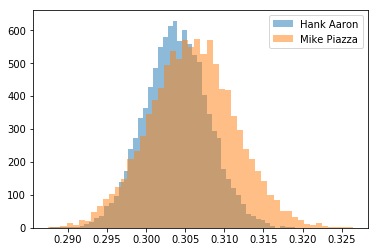

In [4]:
for idx, row in two_players.iterrows():
    plt.hist(beta(row['alpha1'], row['beta1'], size=10000), label=row['name'], alpha=.5, bins=50)
plt.legend();

### Figure 6.2

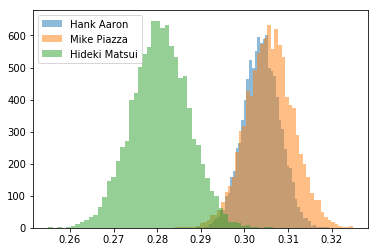

In [5]:
for idx, row in three_players.iterrows():
    plt.hist(beta(row['alpha1'], row['beta1'], size=10000), label=row['name'], alpha=.5, bins=50)
plt.legend();

### Section 6.2.1 - Simulation of posterior draws

In [6]:
piazza_simulation = beta(piazza['alpha1'], piazza['beta1'], size=int(1e6))
aaron_simulation = beta(aaron['alpha1'], aaron['beta1'], size=int(1e6))

(piazza_simulation > aaron_simulation).mean()

0.60758000000000001

### Section 6.2.2 - Integration

I'm probably never going to do things this way so ... meh.

### Section 6.2.3 - Closed-form solution

Can't really get this one to work, but let's be honest -- I use the simulation approach every time.

In [7]:
from scipy.special import betaln

def h(alpha_a, beta_a, alpha_b, beta_b):
    j = np.arange(0, round(alpha_b) - 1)
    log_vals = (betaln(alpha_a + j, beta_a + beta_b) - np.log(beta_b + j) -
                betaln(1 + j, beta_b) - betaln(alpha_a, beta_a))
    return (1 - np.sum(np.exp(log_vals)))

h(piazza['alpha1'], piazza['beta1'], aaron['alpha1'], aaron['beta1'])

ValueError: Wrong number of items passed 3846, placement implies 1

### Section 6.2.4 - Closed-form approximation

In [12]:
def h_approx(alpha_a, beta_a, alpha_b, beta_b):
    u1 = alpha_a / (alpha_a + beta_a)
    u2 = alpha_b / (alpha_b + beta_b)
    var1 = ((alpha_a * beta_a) /
        ((alpha_a + beta_a) ** 2 * (alpha_a + beta_a + 1)))
    var2 = ((alpha_b * beta_b) / 
        ((alpha_b + beta_b) ** 2 * (alpha_b + beta_b + 1)))
    return ss.norm(u2 - u1, np.sqrt(var1 + var2)).cdf(0)


alpha_a = piazza['alpha1'][0]
beta_a = piazza['beta1'][0]
alpha_b = aaron['alpha1'][0]
beta_b = aaron['beta1'][0]

h_approx(alpha_a, beta_a, alpha_b, beta_b)

0.60787909356892034

### Figure 6.4

Will get back to this at some point

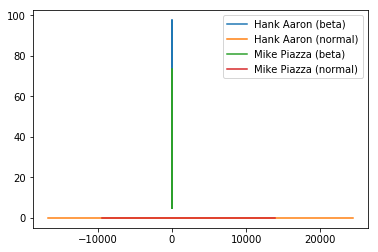

In [13]:
# TODO: finish this
for idx, row in two_players.iterrows():
    beta_x = np.linspace(ss.beta(row['alpha1'], row['beta1']).ppf(0.01),
                         ss.beta(row['alpha1'], row['beta1']).ppf(0.99))
    plt.plot(beta_x, ss.beta(row['alpha1'], row['beta1']).pdf(beta_x), label=row['name'] + ' (beta)')
    
    normal_x = np.linspace(ss.norm(row['alpha1'], row['beta1']).ppf(0.01),
                           ss.norm(row['alpha1'], row['beta1']).ppf(0.99))
    plt.plot(normal_x, ss.norm.pdf(normal_x, row['alpha1'], row['beta1']), label=row['name'] + ' (normal)')
plt.legend()

## Section 6.3 - Confidence and credible intervals

`prop.test` equivalent

In [14]:
contingency_table = (two_players[['name', 'H', 'AB']]
                     .assign(Misses = lambda df: df.apply(lambda r: r['AB'] - r['H'], axis=1))
                     .rename(columns={'H': 'Hits'})
                     .reset_index()
                     [['name', 'Hits', 'Misses']]
                     .set_index('name')
                    )

contingency_table

,Hits,Misses
name,,
Hank Aaron,3771,8593
Mike Piazza,2127,4784


In [15]:
x_squared, p_value, dof, expected = ss.chi2_contingency(contingency_table)

print('x-squared = {}'.format(x_squared))
print('degrees of freedom = {}'.format(dof))
print('p-value = {}'.format(p_value))

x-squared = 0.14759918995919924
degrees of freedom = 1
p-value = 0.7008402975255545


In [16]:
def credible_interval_approx(a, b, c, d):
    u1 = a / (a + b)
    u2 = c / (c + d)
    var1 = a * b / ((a + b) ** 2 * (a + b + 1))
    var2 = c * d / ((c + d) ** 2 * (c + d + 1))

    mu_diff = u2 - u1
    sd_diff = np.sqrt(var1 + var2)

    norm_sim = np.random.normal(mu_diff, sd_diff, size=10000)
    return {
        'posterior': (pd.Series(norm_sim) < 0).mean(),
        'estimate': mu_diff,
        'conf_low': np.percentile(norm_sim, q=2.5),
        'conf_high': np.percentile(norm_sim, q=97.5)
    }

a = piazza['alpha1'][0]
b = piazza['beta1'][0]
c = aaron['alpha1'][0]
d = aaron['beta1'][0]

credible_interval_approx(a, b, c, d)

{'conf_high': 0.011517458976224963,
 'conf_low': -0.015601753893191843,
 'estimate': -0.0018606003171035002,
 'posterior': 0.61460000000000004}

### Figure 6.5

These errorbar boxplot-like charts are a nightmare to do in Python, especially when they have a categorical y-axis.

I would take the small-multiples approach and make histograms for each player, also putting dashed lines at the 95% credible intervals. You can find an example of this in my notebook [here](https://github.com/gjreda/cy-young-NL-2015/blob/master/cy-young.ipynb).